# Classificação NOT-MNIST com CNN

A classificação de imagens em múltiplas classes é um problema cláassico na área de Deep Learning. A
abordagem mais utilizada para resolver este problema é utilizar Redes Neurais Convolucionais (CNNs), pois
recentemente este tipo de rede mostrou um alto desempenho em tarefas de classicação de imagens.  

Um dos datasets para classificação de imagens disponíveis na internet é o NOT-MNIST. Este dataset
contém imagens de caracteres do A ao J, ou seja, 10 classes. As imagens têm dimensão de 28x28 e estão em
tons de cinza, ou seja, um único canal

![exemplo](img/not-mnist.png)

## Metodologia

Para a classsificação desse dataset será utilizada uma CNN implementada com Kera sobre Tensorflow.

### Importando as libs

In [1]:
#Importando as libs necessárias
import numpy as np
np.random.seed(1338) # fixo para permitir reproducibilidade

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Flatten, Activation, Dropout
import tensorflow as tf

from keras.utils import np_utils
from keras.optimizers import SGD
#Libs auxiliares criadas
from util.display import visualize_keras_model, plot_training_curves
import util.tensorboard_utils as tb_util
import util.notMNIST as notMNIST

#Lib para realizar a leitura do arquivo serializado em formato pickle
from six.moves import cPickle

#Lib para deixar os plotagens com um visual melhor
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('white')
%matplotlib inline

Using TensorFlow backend.


### Carregando os dados

In [2]:
notmnist_path = "notMNIST.pickle"
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = notMNIST.load_data(notmnist_path)

#### Preprocessamento e normalização

In [3]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [4]:
# copiando as matrizes originais antes de inserir o canal
x_valid_orig = x_valid
x_test_orig = x_test

# Adicionando a coluna referente ao canal
x_train = x_train.reshape(-1, img_rows, img_cols, 1)
x_valid = x_valid.reshape(-1, img_rows, img_cols, 1)
x_test = x_test.reshape(-1, img_rows, img_cols, 1)

In [5]:
# Convertendo os labels para a forma categorica (one hot encoding)
nb_classes = 10
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [6]:
print('train_dataset:', x_train.shape, '\t|', 'train_labels:', y_train.shape, 
      '\nvalid_dataset:', x_valid.shape, '\t|', 'valid_labels:', y_valid.shape, 
      '\ntest_dataset:', x_test.shape, '\t|', 'test_labels:', y_test.shape)

train_dataset: (200000, 28, 28, 1) 	| train_labels: (200000, 10) 
valid_dataset: (10000, 28, 28, 1) 	| valid_labels: (10000, 10) 
test_dataset: (10000, 28, 28, 1) 	| test_labels: (10000, 10)


### Convolutional Neural Network

Inicialização dos valores para a rede

In [7]:
# Numero de épocas (baixo para quando processado somente em CPU)
nb_epoch = 8

# Tamanho do batch
batch_size =128

# Numero de filtros convolucionais
nb_filters = 32

# Tamanho da area de pooling para o MaxPooling
nb_pool = 2

# Tamanho do kernel convolucional
nb_conv = 3

#### 1 - Definição do modelo

In [8]:
model = Sequential()

# A primeira camada deve especificar o input_shape
# 1 - Camada Convolucional
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
# Camada de nivelamento/achatamento - 1D
model.add(Flatten())
# Camada totalmente conectada
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Camada totalmente conectada
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


In [ ]:
# TODO: pesquisar sobre onde colocar o Dropout

In [9]:
model.summary()
#visualize_keras_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

#### 2 - Compilação

In [10]:
# keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

#### 3 - Treino

In [11]:
# criando callback para tensorboard
tb_callback = tb_util.make_tb_callback('execucao-3')

hist = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_valid, y_valid),
                    callbacks=[tb_callback])

Train on 200000 samples, validate on 10000 samples
Epoch 1/8
200000/200000 [==============================] - 425s - loss: 0.5678 - acc: 0.8316 - val_loss: 0.4028 - val_acc: 0.8783
Epoch 2/8
200000/200000 [==============================] - 426s - loss: 0.4206 - acc: 0.8765 - val_loss: 0.3589 - val_acc: 0.8921
Epoch 3/8
200000/200000 [==============================] - 426s - loss: 0.3864 - acc: 0.8859 - val_loss: 0.3465 - val_acc: 0.8976
Epoch 4/8
200000/200000 [==============================] - 426s - loss: 0.3677 - acc: 0.8908 - val_loss: 0.3291 - val_acc: 0.9007
Epoch 5/8
200000/200000 [==============================] - 430s - loss: 0.3552 - acc: 0.8948 - val_loss: 0.3198 - val_acc: 0.9023
Epoch 6/8
200000/200000 [==============================] - 426s - loss: 0.3453 - acc: 0.8972 - val_loss: 0.3153 - val_acc: 0.9043
Epoch 7/8
200000/200000 [==============================] - 422s - loss: 0.3388 - acc: 0.8992 - val_loss: 0.3126 - val_acc: 0.9035
Epoch 8/8
200000/200000 [==============

## Resultados

Visualizando os resultados obtidos de diversas formas

### 1 - Curvas de Aprendizado

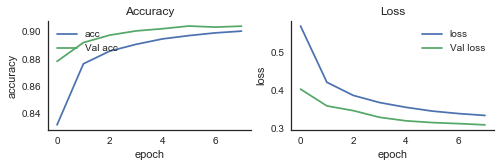

In [12]:
plot_training_curves(hist.history);

### 2 - Validação


In [13]:
print('Métricas disponíveis no modelo: {}'.format(model.metrics_names))

Métricas disponíveis no modelo: ['loss', 'acc']


In [22]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)
print('Teste Loss:', loss)
print('Teste Accuracy:', accuracy)

Teste Loss: 0.309315240717
Teste Accuracy: 0.9042


### 3 - Predições

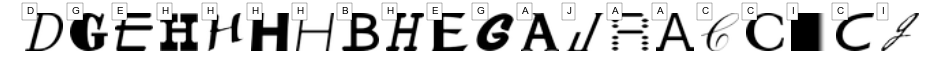

In [21]:
slice = 20
predicted = model.predict(x_test[:slice]).argmax(-1)
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(x_test_orig[i], interpolation='bilinear')
    plt.text(0, 0, classes[predicted[i]], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

### 4 - TensorBoard

Executar no terminal

```bash
nohup tensorboard --logdir=graph-tensorboard/ --port=9999&
```

In [19]:
%%HTML
<iframe width='100%' height='800' src='http://0.0.0.0:9999'></iframe>